In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Daily Data - last 365 rows

from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [43]:
measurement_data = []
results0 = session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs)
for row in results0:
    measurement_data.append(row)
measurement_df = pd.DataFrame(measurement_data,columns=['id','station','date','prcp','tobs'])
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [44]:
# Want precipitation data from 8/23/2016 to 8/23/2017

measurement_data = []
for row in session.query(Measurement.date,Measurement.prcp).all():
    measurement_data.append(row)
    
measurement_df = pd.DataFrame(measurement_data,columns =['date','precipitation'])

measurement_date_index = measurement_df.set_index('date')

measurement_sorted = measurement_date_index.sort_index(ascending=True)

Aug2016_Aug2017 = measurement_sorted.loc['2016-08-23':'2017-08-23']

Aug2016_Aug2017_no_null = Aug2016_Aug2017.dropna(subset=['precipitation'])

Aug2016_Aug2017_no_null.head()
    

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.70
2016-08-23,1.79
2016-08-23,0.02
2016-08-23,0.15


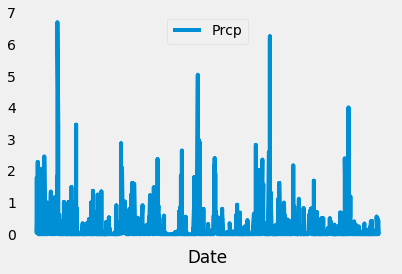

In [45]:
fig, ax = plt.subplots()
plt.plot(Aug2016_Aug2017_no_null,label='Prcp')
ax.tick_params(labelbottom=False)
ax.set_xlabel('Date')

plt.legend(loc='upper center')
plt.grid()
plt.savefig("./Images/Precipitation.png")
plt.show()

In [46]:
# Use Pandas to calcualte the summary statistics for the precipitation data

Aug2016_Aug2017_no_null.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [47]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

new_station = []
unique_station = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc())
for station in unique_station:
    new_station.append(station)
new_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active = []
most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.\
avg(Measurement.tobs)).filter_by(station='USC00519281')
for num in most_active:
    active.append(num)
active

[(54.0, 85.0, 71.66378066378067)]

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Want tobs data from 8/23/2016 to 8/23/2017

active_tobs_data = []
for row in session.query(Measurement.date,Measurement.tobs).filter_by(station='USC00519281'):
    active_tobs_data.append(row)
    
tobs_df = pd.DataFrame(active_tobs_data,columns =['date','tobs'])

tobs_date_index = tobs_df.set_index('date')

tobs_sorted = tobs_date_index.sort_index(ascending=True)

Aug2016_Aug2017_tobs = tobs_sorted.loc['2016-08-23':'2017-08-23']

Aug2016_Aug2017_no_null_tobs = Aug2016_Aug2017_tobs.dropna(subset=['tobs'])

Aug2016_Aug2017_no_null_tobs.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


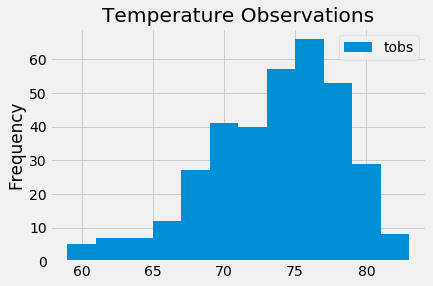

In [51]:
Aug2016_Aug2017_no_null_tobs.hist(column='tobs',label='tobs',bins=12)

plt.title('Temperature Observations')

plt.ylabel('Frequency')

plt.legend()
plt.savefig("./Images/tobs.png")
plt.show()

In [52]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
temps = calc_temps('2017-02-28', '2017-03-05')

In [53]:
# Trip Dates --> 2017-02-28 to 2017-03-05

trip_temp = calc_temps('2017-02-28', '2017-03-05')
trip_temp

[(64.0, 72.02777777777777, 78.0)]

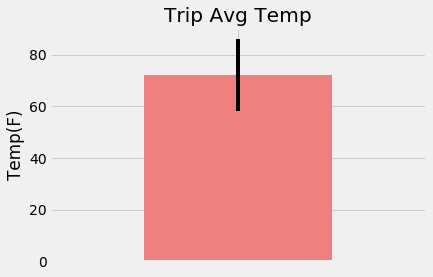

In [54]:
trip_temp_df = pd.DataFrame(temps,columns=['tmin','tavg','tmax'])

peak = trip_temp_df['tmax'] - trip_temp_df['tmin']

trip_temp_df['tavg'].plot(kind='bar',yerr=peak,color='lightcoral')

plt.tick_params(labelbottom=False)
plt.title("Trip Avg Temp")
plt.ylabel('Temp(F)')

plt.savefig("./Images/trip_temp.png")
plt.show()

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [56]:
station_data = []
results = session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation)
for row in results:
    station_data.append(row)
station_df = pd.DataFrame(station_data,columns=['id','name','location','latitude','longitude','elevation'])
station_df

,id,name,location,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [57]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# 2011-02-28 to 2011-03-05

def calc_rainfall(start_date, end_date):
     
    return session.query(Station.station,Station.name,Station.latitude,Station.\
longitude,Station.elevation,func.avg(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
filter(Measurement.station == Station.station).filter(Measurement.prcp.isnot(None)).\
group_by(Station.station).order_by(func.avg(Measurement.prcp).desc()).all()

print(calc_rainfall('2017-02-28','2017-03-05'))

[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.9933333333333333), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.7866666666666667), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.7416666666666667), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6783333333333333), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.5800000000000001), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.46399999999999997), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.4566666666666666)]


In [58]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("02-28")

[(65.0, 70.65517241379311, 80.0)]

In [59]:
# Trip Dates 2011-02-28 to 2011-03-05

import datetime

dates = []

start = datetime.datetime.strptime("02-28", "%m-%d")
end = datetime.datetime.strptime("03-06", "%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

for date in date_generated:
    dates.append(date.strftime("%m-%d"))

dates

['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']

In [60]:
normals = []

for date in dates:
    normals.append(daily_normals(date))
    
from itertools import chain
new_normals = list(chain(*normals))
    
new_normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [61]:
new_dates = []
for date in dates:
    new_dates.append(date + '-2017')

newer_dates = []
for item in new_dates:
    newer_dates.append(datetime.datetime.strptime(item,'%m-%d-%y').strftime('%y-%m-%d'))

In [62]:
normals_df = pd.DataFrame(new_normals,columns=['tmin','tavg','tmax'])
new_dates_df = pd.DataFrame(new_dates,columns=['Date'])
new_normals_df = pd.merge(normals_df,new_dates_df,left_index=True,right_index=True)
new_normals_df2 = new_normals_df.set_index('Date')
new_normals_df2

,tmin,tavg,tmax
Date,,,
02-28-2017,65.0,70.655172,80.0
03-01-2017,64.0,70.032787,76.0
03-02-2017,61.0,70.366667,78.0
03-03-2017,60.0,70.068966,78.0
03-04-2017,57.0,69.272727,77.0
03-05-2017,60.0,67.890909,76.0


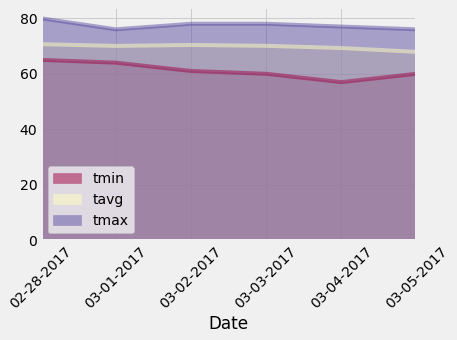

In [63]:
new_normals_df2.plot(kind='area',stacked=False,colormap='Spectral',rot=45)
plt.savefig("./Images/area_plot.png")
plt.show()

In [ ]:
# Date formatting - looping, area chart...markdown code
# Verify rainfall data...avg or sum ?
# error bars on the avg temp chart...peak to peak(min/max)
# save figures to contain entire graph in png